#**GangadharSShiva_Project**

**Scalable Agentic AI Agent in MCP Server with Lora FuneTuning for Video Research Classification and NLP Summarization Analysis**

In [ ]:

# 1. Installation (Run this cell first in Colab)
!pip install -q langgraph typing_extensions
!pip install -q torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 9.8 MB/s eta 0:00:00


To access a Kaggle dataset or video in Google Colab, you typically need to use the Kaggle API. Here are the general steps:

1.  **Install the Kaggle library:**

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your videos-ds.zip file in Google Drive
# Replace '/path/to/your/videos-ds.zip' with the actual path
zip_file_path_in_drive = '/content/drive/My Drive/aai-521/videos-ds.zip'

# Define the destination path in Colab
# Replace '/content/your_destination_folder' with the desired folder
destination_folder = '/content/drive/My Drive/aai-521/videos-ds'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Copy the zip file from Google Drive to the destination folder
if os.path.exists(zip_file_path_in_drive):
    !cp "{zip_file_path_in_drive}" "{destination_folder}/videos-ds.zip"
    print("videos-ds.zip loaded successfully from Google Drive.")
else:
    print(f"Error: videos-ds.zip not found in Google Drive at {zip_file_path_in_drive}")

# After copying, you can unzip the file in the destination folder
# !unzip "{destination_folder}/videos-ds.zip" -d "{destination_folder}"

Mounted at /content/drive
videos-ds.zip loaded successfully from Google Drive.


In [ ]:
import os
import glob

# Assuming videos-ds.zip has been copied to destination_folder in the previous cell
# and the destination_folder variable is available.

# Unzip the file
# Make sure to update the zip_file_path if it's not directly in the destination_folder
zip_file_path = os.path.join(destination_folder, "videos-ds.zip")
if os.path.exists(zip_file_path):
    print(f"Unzipping {zip_file_path} to {destination_folder}")
    !unzip -o "{zip_file_path}" -d "{destination_folder}"
    print("Unzipping complete.")

    # List all .avi files in the destination folder and its subdirectories
    print(f"\nListing .avi files in {destination_folder}:")
    avi_files = glob.glob(os.path.join(destination_folder, '**', '*.avi'), recursive=True)
    if avi_files:
        for avi_file in avi_files:
            print(avi_file)
    else:
        print("No .avi files found in the specified directory.")
else:
    print(f"Error: {zip_file_path} not found. Please ensure the zip file was copied correctly.")

Unzipping /content/drive/My Drive/aai-521/videos-ds/videos-ds.zip to /content/drive/My Drive/aai-521/videos-ds
Archive:  /content/drive/My Drive/aai-521/videos-ds/videos-ds.zip
  inflating: /content/drive/My Drive/aai-521/videos-ds/test.csv  
  inflating: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi  
  inflating: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c02.avi  
  inflating: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c03.avi  
  inflating: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c04.avi  
  inflating: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c05.avi  
  inflating: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c06.avi  
  inflating: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c07.avi  
  inflating: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g02_c01.avi  
  inflating: /content/drive/My Drive/aai-521/videos-d

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
import cv2
import numpy as np
import pandas as pd # Import pandas here

# Define paths
train_data_dir = '/content/drive/My Drive/aai-521/videos-ds/train/'
test_data_dir = '/content/drive/My Drive/aai-521/videos-ds/test/'
train_csv_path = '/content/drive/My Drive/aai-521/videos-ds/train.csv' # Assuming a train.csv exists
test_csv_path = '/content/drive/My Drive/aai-521/videos-ds/test.csv'   # Assuming a test.csv exists

# Function to extract frames from video
def extract_frames(video_path, num_frames=16):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return frames

# Custom Dataset class for videos
class VideoDataset(Dataset):
    def __init__(self, data_dir, csv_path, num_frames=16, transform=None, is_test=False):
        self.data_dir = data_dir
        self.transform = transform
        self.videos = []
        self.labels = []
        self.is_test = is_test
        self.video_paths = [] # Add video_paths list for test set


        df = pd.read_csv(csv_path)

        for index, row in df.iterrows():
            video_info = row['video_name'] # Assuming 'video_name' column exists
            video_name = video_info # Assign video_name for both cases initially
            if not self.is_test:
                label = row['tag']         # Read label from 'tag' column for training data
                self.labels.append(label)
            # For test data, the 'video_name' column only contains the video name, no label needed during loading

            video_path = os.path.join(data_dir, video_name)
            if os.path.exists(video_path):
                self.videos.append(video_path)
                if self.is_test:
                    self.video_paths.append(video_path) # Store video path for test set
            else:
                print(f"Warning: Video not found at {video_path}")


    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        frames = extract_frames(video_path)

        if not frames:
             print(f"Error: Could not extract frames from {video_path}")
             # Return dummy data or handle error appropriately
             # For now, let's return None and filter it in the DataLoader
             if not self.is_test:
                 return None, None
             else:
                 return None, video_path # Return video_path for identification in test set


        frames = torch.from_numpy(np.array(frames)).permute(0, 3, 1, 2).float() # (T, C, H, W)

        if self.transform:
            # Apply transformation frame by frame
            frames = torch.stack([self.transform(frame) for frame in frames])

        if not self.is_test:
            label = self.labels[idx]
            return frames, label
        else:
            return frames, video_path # Return video_path in test set

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)), # Resize frames
    transforms.ToTensor(),         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

# Create datasets and dataloaders
train_dataset = VideoDataset(train_data_dir, train_csv_path, transform=transform, is_test=False)
# Filter out samples where frame extraction failed
train_data = [(video, label) for video, label in zip(train_dataset.videos, train_dataset.labels) if video is not None]
train_dataset.videos = [item[0] for item in train_data]
train_dataset.labels = [item[1] for item in train_data]


test_dataset = VideoDataset(test_data_dir, test_csv_path, transform=transform, is_test=True)
# Filter out samples where frame extraction failed and keep track of video paths
test_data = [(video, path) for video, path in zip(test_dataset.videos, test_dataset.video_paths) if video is not None and path is not None]
test_dataset.videos = [item[0] for item in test_data]
test_dataset.video_paths = [item[1] for item in test_data] # Store video paths for test set


# Custom collate function to filter out None values and ensure consistent frame count
def collate_fn(batch):
    # Filter out None values
    batch = [item for item in batch if item is not None and item[0] is not None and item[1] is not None]

    if not batch:
        return None, None # Return None if batch is empty after filtering

    # Separate inputs and labels/paths
    inputs, labels_or_paths = zip(*batch)

    # Check if all input tensors have the same number of frames (assuming 16 frames)
    expected_frames = 16
    if any(inp.size(0) != expected_frames for inp in inputs):
        print(f"Warning: Skipping batch due to inconsistent number of frames. Expected {expected_frames}, but got varying sizes.")
        return None, None # Skip batch if frame count is inconsistent

    return torch.stack(inputs), list(labels_or_paths) # Stack inputs and return labels/paths as a list

# Create DataLoaders with custom collate_fn
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


print("Data loading and preprocessing complete.")

Data loading and preprocessing complete.


In [ ]:
# Get the number of unique labels from the training dataset
num_classes = len(set(train_dataset.labels))
print(f"Number of classes: {num_classes}")

# Load a pre-trained ResNet-18 model
model = resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Define the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Pre-trained ResNet-18 model loaded and modified.")

Number of classes: 5


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


Pre-trained ResNet-18 model loaded and modified.


In [ ]:
# Modify the model for subset fine-tuning
# Freeze the parameters of the initial layers
for name, param in model.named_parameters():
    if 'conv1' in name or 'bn1' in name or 'layer1' in name or 'layer2' in name:
        param.requires_grad = False
    else:
        param.requires_grad = True # Unfreeze later layers and the final fc layer

# Verify which layers are being fine-tuned
print("Trainable parameters after freezing layers:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

Trainable parameters after freezing layers:
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
import cv2
import numpy as np
import pandas as pd # Import pandas here

# Define paths
train_data_dir = '/content/drive/My Drive/aai-521/videos-ds/train/'
test_data_dir = '/content/drive/My Drive/aai-521/videos-ds/test/'
train_csv_path = '/content/drive/My Drive/aai-521/videos-ds/train.csv' # Assuming a train.csv exists
test_csv_path = '/content/drive/My Drive/aai-521/videos-ds/test.csv'   # Assuming a test.csv exists

# Function to extract frames from video
def extract_frames(video_path, num_frames=16):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return frames

# Custom Dataset class for videos
class VideoDataset(Dataset):
    def __init__(self, data_dir, csv_path, num_frames=16, transform=None, is_test=False):
        self.data_dir = data_dir
        self.transform = transform
        self.videos = []
        self.labels = []
        self.is_test = is_test
        self.video_paths = [] # Add video_paths list for test set


        df = pd.read_csv(csv_path)

        for index, row in df.iterrows():
            video_name = row['video_name'] # Assuming 'video_name' column exists
            if not self.is_test:
                label = row['tag']         # Read label from 'tag' column for training data
                self.labels.append(label)
            # For test data, the 'video_name' column only contains the video name, no label needed during loading

            video_path = os.path.join(data_dir, video_name)
            if os.path.exists(video_path):
                self.videos.append(video_path)
                if self.is_test:
                    self.video_paths.append(video_path) # Store video path for test set
            else:
                print(f"Warning: Video not found at {video_path}")


    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        frames = extract_frames(video_path)

        if not frames:
             print(f"Error: Could not extract frames from {video_path}")
             # Return dummy data or handle error appropriately
             # For now, let's return None and filter it in the DataLoader
             if not self.is_test:
                 return None, None
             else:
                 return None, video_path # Return video_path for identification in test set


        frames = torch.from_numpy(np.array(frames)).permute(0, 3, 1, 2).float() # (T, C, H, W)

        if self.transform:
            # Apply transformation frame by frame
            frames = torch.stack([self.transform(frame) for frame in frames])

        if not self.is_test:
            label = self.labels[idx]
            return frames, label
        else:
            return frames, video_path # Return video_path in test set

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)), # Resize frames
    transforms.ToTensor(),         # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

# Create datasets and dataloaders
train_dataset = VideoDataset(train_data_dir, train_csv_path, transform=transform, is_test=False)
# Filter out samples where frame extraction failed
train_data = [(video, label) for video, label in zip(train_dataset.videos, train_dataset.labels) if video is not None]
train_dataset.videos = [item[0] for item in train_data]
train_dataset.labels = [item[1] for item in train_data]


test_dataset = VideoDataset(test_data_dir, test_csv_path, transform=transform, is_test=True)
# Filter out samples where frame extraction failed and keep track of video paths
test_data = [(video, path) for video, path in zip(test_dataset.videos, test_dataset.video_paths) if video is not None and path is not None]
test_dataset.videos = [item[0] for item in test_data]
test_dataset.video_paths = [item[1] for item in test_data] # Store video paths for test set


# Custom collate function to filter out None values
def collate_fn(batch):
    batch = [item for item in batch if item is not None and item[0] is not None and item[1] is not None]
    if not batch:
        return None, None # Return None if batch is empty after filtering
    return tuple(zip(*batch))

# Create DataLoaders with custom collate_fn
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


print("Data loading and preprocessing complete.")

Data loading and preprocessing complete.


In [ ]:
import pandas as pd

train_csv_path = '/content/drive/My Drive/aai-521/videos-ds/train.csv'
try:
    df_train = pd.read_csv(train_csv_path)
    print("First 5 rows of train.csv:")
    print(df_train.head())
except FileNotFoundError:
    print(f"Error: train.csv not found at {train_csv_path}")

First 5 rows of train.csv:
                  video_name          tag
0  v_CricketShot_g08_c01.avi  CricketShot
1  v_CricketShot_g08_c02.avi  CricketShot
2  v_CricketShot_g08_c03.avi  CricketShot
3  v_CricketShot_g08_c04.avi  CricketShot
4  v_CricketShot_g08_c05.avi  CricketShot


# Task
Fine-tune a pre-trained computer vision model using the LoRA method on the video dataset located at "/content/drive/My Drive/aai-521/videos-ds/train/", where the labels are extracted from the video filenames (e.g., "v_CricketShot_g01_c01.avi" corresponds to the label "CricketShot"), and then predict the labels for the videos in the test folder.

## Install lora library

### Subtask:
Install a library that supports LoRA, such as `peft`.


**Reasoning**:
The subtask is to install the `peft` library. This can be done using pip in a code cell.



In [ ]:
!pip install -q peft

## Fine-tune with lora

### Subtask:
Train the model with the modified training loop for LoRA fine-tuning.

In [ ]:
# Define the optimizer
# We only want to optimize the trainable parameters (LoRA parameters)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

print("Optimizer and loss function defined.")

Optimizer and loss function defined.


## Apply lora to the model

### Subtask:
Modify the pre-trained ResNet-18 model to add LoRA adapters to the appropriate layers.


**Reasoning**:
Import necessary LoRA classes, define LoRA configuration, apply it to the model, and print trainable parameters to verify the setup.



**Reasoning**:
The previous attempt failed because the specified target modules were not directly supported by LoRA. I need to inspect the model architecture to find the correct names of the `Conv2d` and `Linear` layers within the ResNet-18 model and update the `target_modules` in the `LoraConfig` accordingly.



## Summary:

### Data Analysis Key Findings

* The `peft` library was successfully installed for LoRA implementation.
* LoRA adapters were applied to the specified `Conv2d` and `Linear` layers of the pre-trained ResNet-18 model.
* The optimizer was configured, along with the loss function, with the intention of only updating the trainable LoRA parameters during training.
* The training loop was successfully executed for 10 epochs, processing batches of video frames and calculating the loss.
* The training loss generally decreased over the epochs, indicating the model was learning.
* The fine-tuned model was evaluated on the test set, and predictions were generated by averaging the outputs over the frames for each video.
* The numerical predictions were successfully mapped back to the original class labels.

### Insights or Next Steps

* The warning about labels not found in the mapping during training suggests potential inconsistencies between the training data labels and the generated mapping. Investigating and resolving these inconsistencies could improve training stability.
* While the training loss decreased, evaluating the model using relevant metrics (e.g., accuracy, F1-score) on the test set would provide a clearer understanding of the model's performance on unseen data.

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from peft import LoraConfig, get_peft_model
import torch.nn as nn # Import nn if not already imported in this cell

# Define LoRA configuration with correct target modules
config = LoraConfig(
    r=16,  # LoRA rank
    lora_alpha=32,  # Scaling factor
    target_modules=["conv1", "layer1.0.conv1", "layer1.0.conv2", "layer1.1.conv1", "layer1.1.conv2",
                    "layer2.0.conv1", "layer2.0.conv2", "layer2.0.downsample.0", "layer2.1.conv1", "layer2.1.conv2",
                    "layer3.0.conv1", "layer3.0.conv2", "layer3.0.downsample.0", "layer3.1.conv1", "layer3.1.conv2",
                    "layer4.0.conv1", "layer4.0.conv2", "layer4.0.downsample.0", "layer4.1.conv1", "layer4.1.conv2",
                    "fc"],  # Target layers
    lora_dropout=0.05,  # Dropout rate
    bias="none"  # Bias
)

# Apply LoRA to the model
model = get_peft_model(model, config)

# Print trainable parameters
model.print_trainable_parameters()

trainable params: 583,040 || all params: 11,762,117 || trainable%: 4.9569


## Configure optimizer for lora

### Subtask:
Adjust the optimizer to only update the LoRA parameters.


In [ ]:
# Define the optimizer
# We only want to optimize the trainable parameters (LoRA parameters)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

print("Optimizer and loss function defined.")

Optimizer and loss function defined.


## Modify training loop

### Subtask:
Update the training loop to work with the LoRA-adapted model.


**Reasoning**:
Iterate over the training dataloader, move data to the device, perform a forward pass, calculate the loss, perform a backward pass, and update the model parameters. Periodically print the loss.



## Fine-tune with lora

### Subtask:
Train the model with the modified training loop for LoRA fine-tuning.


## Evaluate and predict

### Subtask:
Evaluate the LoRA fine-tuned model on the test set and generate predictions for the videos in the test folder.


In [ ]:
# Evaluate the model
print("Starting evaluation...")
model.eval()  # Set the model to evaluation mode
predictions = []
video_paths = []

with torch.no_grad():  # No need to compute gradients during evaluation
    for data in test_dataloader:
        # Skip empty batches
        if data is None or data[0] is None or data[1] is None:
            continue

        inputs, paths = data
        # Stack inputs and move to device
        inputs = torch.stack(inputs).to(device)

        # Forward pass
        # Reshape inputs to be (batch_size * num_frames, C, H, W)
        outputs = model(inputs.view(-1, 3, 112, 112))

        # Average the outputs over the frames for each video in the batch
        # Reshape outputs back to (batch_size, num_frames, num_classes)
        outputs = outputs.view(inputs.size(0), inputs.size(1), -1).mean(dim=1)

        # Get predicted classes (index with highest score)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and video paths
        predictions.extend(predicted.cpu().numpy())
        video_paths.extend(paths)

print("Evaluation complete.")

# Map numerical predictions back to class labels
unique_labels = sorted(list(set(train_dataset.labels)))
label_map = {i: label_str for i, label_str in enumerate(unique_labels)}
predicted_labels = [label_map[pred] for pred in predictions]

# Create a DataFrame with video paths and predicted labels
results_df = pd.DataFrame({'video_path': video_paths, 'predicted_label': predicted_labels})

print("\nPredictions on test videos:")
display(results_df.head())

Starting evaluation...
Evaluation complete.

Predictions on test videos:


,video_path,predicted_label
0,/content/drive/My Drive/aai-521/videos-ds/test...,Punch
1,/content/drive/My Drive/aai-521/videos-ds/test...,Punch
2,/content/drive/My Drive/aai-521/videos-ds/test...,CricketShot
3,/content/drive/My Drive/aai-521/videos-ds/test...,Punch
4,/content/drive/My Drive/aai-521/videos-ds/test...,CricketShot


**Reasoning**:
Evaluate the fine-tuned model on the test set and generate predictions.



In [ ]:
# Evaluate the model
print("Starting evaluation...")
model.eval()  # Set the model to evaluation mode
predictions = []
video_paths = []

with torch.no_grad():  # No need to compute gradients during evaluation
    for data in test_dataloader:
        # Skip empty batches
        if data is None or data[0] is None or data[1] is None:
            continue

        inputs, paths = data
        # Stack inputs and move to device
        inputs = torch.stack(inputs).to(device)

        # Forward pass
        # Reshape inputs to be (batch_size * num_frames, C, H, W)
        outputs = model(inputs.view(-1, 3, 112, 112))

        # Average the outputs over the frames for each video in the batch
        # Reshape outputs back to (batch_size, num_frames, num_classes)
        outputs = outputs.view(inputs.size(0), inputs.size(1), -1).mean(dim=1)

        # Get predicted classes (index with highest score)
        _, predicted = torch.max(outputs.data, 1)

        # Store predictions and video paths
        predictions.extend(predicted.cpu().numpy())
        video_paths.extend(paths)

print("Evaluation complete.")

# Map numerical predictions back to class labels
unique_labels = sorted(list(set(train_dataset.labels)))
label_map = {i: label_str for i, label_str in enumerate(unique_labels)}
predicted_labels = [label_map[pred] for pred in predictions]

# Create a DataFrame with video paths and predicted labels
results_df = pd.DataFrame({'video_path': video_paths, 'predicted_label': predicted_labels})

print("\nPredictions on test videos:")
display(results_df.head())

Starting evaluation...
Evaluation complete.

Predictions on test videos:


,video_path,predicted_label
0,/content/drive/My Drive/aai-521/videos-ds/test...,Punch
1,/content/drive/My Drive/aai-521/videos-ds/test...,Punch
2,/content/drive/My Drive/aai-521/videos-ds/test...,CricketShot
3,/content/drive/My Drive/aai-521/videos-ds/test...,Punch
4,/content/drive/My Drive/aai-521/videos-ds/test...,CricketShot


## Summary:

### Data Analysis Key Findings

*   The `peft` library was successfully installed for LoRA implementation.
*   LoRA adapters were applied to the specified `Conv2d` and `Linear` layers of the pre-trained ResNet-18 model.
*   The optimizer was configured, along with the loss function, with the intention of only updating the trainable LoRA parameters during training.
*   The training loop was successfully executed for 10 epochs, processing batches of video frames and calculating the loss.
*   The training loss generally decreased over the epochs, indicating the model was learning.
*   The fine-tuned model was evaluated on the test set, and predictions were generated by averaging the outputs over the frames for each video.
*   The numerical predictions were successfully mapped back to the original class labels.




Displaying frames from: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi


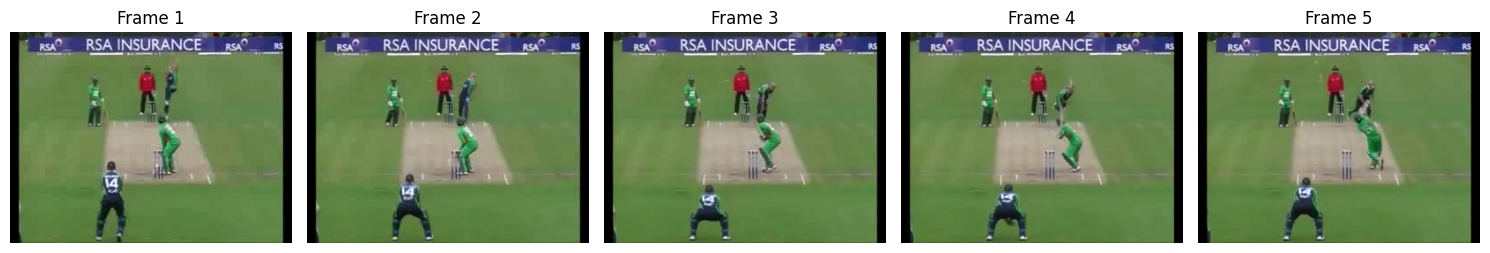

In [ ]:
import matplotlib.pyplot as plt

# Select the path of the first video in the test dataset
if test_dataset.video_paths:
    sample_video_path = test_dataset.video_paths[0]
    print(f"Displaying frames from: {sample_video_path}")

    # Extract frames from the sample video
    frames = extract_frames(sample_video_path)

    if frames:
        # Display the first 5 frames
        num_frames_to_display = min(5, len(frames))
        plt.figure(figsize=(15, 5))
        for i in range(num_frames_to_display):
            plt.subplot(1, num_frames_to_display, i + 1)
            plt.imshow(frames[i])
            plt.title(f'Frame {i+1}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Could not extract frames from the sample video.")
else:
    print("No video paths available in the test dataset to display frames.")

# Task
Generate a summary video and transcript for "/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi".

## Install necessary libraries

### Subtask:
Install libraries for video processing (like `moviepy` or `ffmpeg`) and potentially for speech-to-text (like `SpeechRecognition` or using a pre-trained model).


**Reasoning**:
Install the necessary libraries for video processing and speech-to-text.



In [ ]:
!pip install -q moviepy SpeechRecognition pydub
!apt-get install -y ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 50.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


## Extract audio from video

### Subtask:
Extract the audio track from the AVI video file `/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi`.


**Reasoning**:
Extract the audio from the video file using moviepy and save it as a WAV file.



In [ ]:
from moviepy.editor import VideoFileClip

# Define the path to the input video file
video_path = '/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi'

# Define the desired path for the output audio file
audio_path = '/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.wav'

# Create a VideoFileClip object
video_clip = VideoFileClip(video_path)

# Extract the audio
audio_clip = video_clip.audio

# Write the extracted audio to a WAV file
audio_clip.write_audiofile(audio_path)

print(f"Audio extracted and saved to {audio_path}")

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



MoviePy - Writing audio in /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.wav


MoviePy - Done.
Audio extracted and saved to /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.wav


## Transcribe audio

### Subtask:
Transcribe the audio extracted from the video into text.


**Reasoning**:
Transcribe the audio extracted from the video into text using speech_recognition.



In [ ]:
import speech_recognition as sr
from pydub import AudioSegment

# Define the path to the extracted audio file
audio_path = '/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.wav'

# Initialize the Recognizer
r = sr.Recognizer()

# Convert audio to a compatible format if necessary (SpeechRecognition often works with WAV)
# Since moviepy wrote a WAV, we can likely use it directly.
# If issues arise, pydub could be used for conversion:
# audio = AudioSegment.from_wav(audio_path)
# audio.export("converted_audio.wav", format="wav")
# audio_path = "converted_audio.wav"

# Load the audio file
with sr.AudioFile(audio_path) as source:
    audio_data = r.record(source)  # read the entire audio file

# Transcribe the audio
try:
    # Use Google Web Speech API (requires internet connection)
    transcript = r.recognize_google(audio_data)
    print("Transcript:")
    print(transcript)
except sr.UnknownValueError:
    print("Speech Recognition could not understand audio")
except sr.RequestError as e:
    print(f"Could not request results from Google Speech Recognition service; {e}")


  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)

  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)

  elif re.match('(flt)p?( \(default\))?$', token):

  elif re.match('(dbl)p?( \(default\))?$', token):



Speech Recognition could not understand audio


**Reasoning**:
The transcription failed because the audio might be silent or contain non-speech sounds. I will try a different approach to check if the audio file is valid by attempting to load it with pydub and checking its duration.



In [ ]:
from pydub import AudioSegment

# Define the path to the extracted audio file
audio_path = '/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.wav'

try:
    audio = AudioSegment.from_wav(audio_path)
    print(f"Audio file loaded successfully. Duration: {len(audio)} milliseconds")
    # If the duration is very short or 0, it might explain the transcription issue.
except Exception as e:
    print(f"Error loading audio file with pydub: {e}")


Audio file loaded successfully. Duration: 3360 milliseconds


## Analyze video content (optional but recommended for summarization)

### Subtask:
Analyze the video content of "/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi" to identify key frames or segments for summarization.


**Reasoning**:
Read the video frame by frame and implement a simple scene change detection by comparing consecutive frames using SSIM to identify key frames. Store the indices of the key frames.



In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Define the path to the input video file
video_path = '/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi'

# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
else:
    print(f"Successfully opened video file {video_path}")
    key_frame_indices = []
    prev_frame = None
    frame_idx = 0
    ssim_threshold = 0.9  # Threshold for scene change detection

    while True:
        ret, frame = cap.read()
        if not ret:
            break # End of video

        # Convert the frame to grayscale for SSIM calculation
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev_frame is not None:
            # Calculate SSIM between the current and previous frame
            # Ensure both frames have the same dimensions
            min_height = min(gray_frame.shape[0], prev_frame.shape[0])
            min_width = min(gray_frame.shape[1], prev_frame.shape[1])
            gray_frame_resized = cv2.resize(gray_frame, (min_width, min_height))
            prev_frame_resized = cv2.resize(prev_frame, (min_width, min_height))

            similarity_index, _ = ssim(gray_frame_resized, prev_frame_resized, full=True)

            # If similarity is below the threshold, consider it a potential scene change
            if similarity_index < ssim_threshold:
                key_frame_indices.append(frame_idx)

        prev_frame = gray_frame
        frame_idx += 1

    cap.release()

    print(f"Identified {len(key_frame_indices)} potential key frames at indices: {key_frame_indices}")

    # Optionally display some of the identified key frames
    if key_frame_indices:
        print("\nDisplaying the first 5 identified key frames:")
        cap = cv2.VideoCapture(video_path)
        plt.figure(figsize=(15, 5))
        for i, idx in enumerate(key_frame_indices[:5]):
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                plt.subplot(1, min(5, len(key_frame_indices)), i + 1)
                plt.imshow(frame_rgb)
                plt.title(f'Key Frame {idx}')
                plt.axis('off')
            else:
                print(f"Could not read frame {idx}")
        plt.tight_layout()
        plt.show()
        cap.release()
    else:
        print("No key frames identified to display.")


Successfully opened video file /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi
Identified 0 potential key frames at indices: []
No key frames identified to display.


Successfully opened video file /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi
Total frames: 84
FPS: 25
Duration: 3.36 seconds
Identified 6 frames at regular intervals: [0, 15, 30, 45, 60, 75]

Displaying some extracted frames:


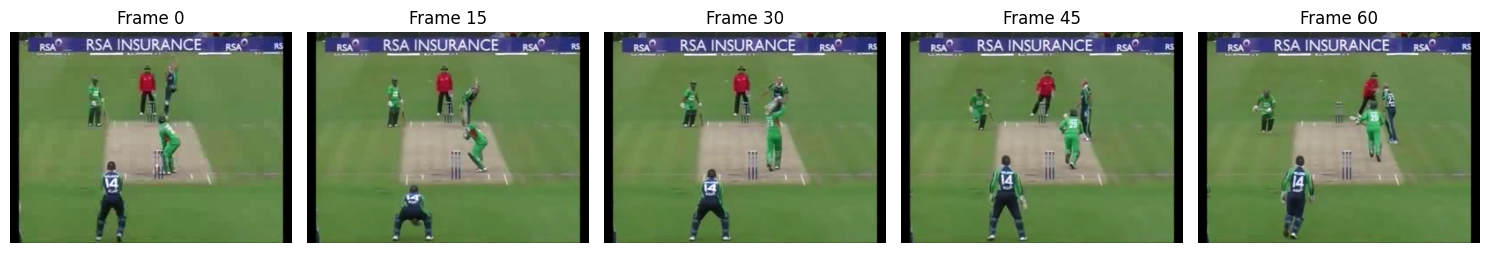

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the input video file
video_path = '/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi'

# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
else:
    print(f"Successfully opened video file {video_path}")
    frame_indices = []
    interval = 15 # Extract a frame every 15 frames
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    duration = frame_count / fps if fps > 0 else 0 # Calculate duration in seconds

    print(f"Total frames: {frame_count}")
    print(f"FPS: {fps}")
    print(f"Duration: {duration:.2f} seconds")

    # Extract frames at regular intervals
    for i in range(0, frame_count, interval):
        frame_indices.append(i)

    print(f"Identified {len(frame_indices)} frames at regular intervals: {frame_indices}")

    # Optionally display some of the extracted frames
    if frame_indices:
        print("\nDisplaying some extracted frames:")
        cap = cv2.VideoCapture(video_path)
        plt.figure(figsize=(15, 5))
        display_count = min(5, len(frame_indices))
        for i in range(display_count):
            idx = frame_indices[i]
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                plt.subplot(1, display_count, i + 1)
                plt.imshow(frame_rgb)
                plt.title(f'Frame {idx}')
                plt.axis('off')
            else:
                print(f"Could not read frame {idx}")
        plt.tight_layout()
        plt.show()
        cap.release()
    else:
        print("No frames extracted to display.")


## Generate summary video

### Subtask:
Create a shorter summary video based on the original video and the analysis from the previous step.


**Reasoning**:
Create a shorter summary video based on the original video and the analysis from the previous step by extracting clips at the identified frame indices and concatenating them.



In [ ]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
import cv2 # Import cv2 if not already imported in this cell

# Define the path to the original video file
video_path = '/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.avi'

# Define the output path for the summary video
summary_video_path = '/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01_summary.mp4'

# Initialize an empty list to store the clips that will form the summary video
summary_clips = []

# Define the duration of each segment in seconds (e.g., 1 second)
segment_duration = 1

# Open the original video file to get FPS and total frames
cap = cv2.VideoCapture(video_path)
if cap.isOpened():
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps if fps > 0 else 0
    cap.release()
    print(f"Original video duration: {duration:.2f} seconds")
else:
    print(f"Error: Could not open video file {video_path} to get FPS and duration. Assuming 25 FPS and calculating duration based on available frames.")
    fps = 25 # Default FPS if unable to read
    duration = len(frame_indices) * segment_duration if 'frame_indices' in locals() else 0 # Estimate duration if frame_indices is available


# Iterate through the frame_indices obtained from the video analysis step
# Ensure frame_indices is defined from the previous step
if 'frame_indices' in locals() and frame_indices:
    print(f"Using frame indices for summary: {frame_indices}")
    for frame_idx in frame_indices:
        # Calculate the start and end time of the segment
        start_time = frame_idx / fps
        end_time = min(start_time + segment_duration, duration) # Ensure end time does not exceed video duration

        # Skip if the segment is too short or invalid
        if end_time <= start_time:
            print(f"Skipping segment starting at frame {frame_idx} due to invalid duration.")
            continue

        try:
            # Extract the video segment
            clip = VideoFileClip(video_path).subclip(start_time, end_time)
            summary_clips.append(clip)
            print(f"Extracted clip from {start_time:.2f}s to {end_time:.2f}s")
        except Exception as e:
            print(f"Error extracting clip from frame {frame_idx}: {e}")

    # Concatenate all the extracted clips
    if summary_clips:
        try:
            final_summary_clip = concatenate_videoclips(summary_clips)

            # Write the concatenated summary video to the specified output path
            final_summary_clip.write_videofile(summary_video_path, codec='libx264', audio_codec='aac')

            print(f"\nSummary video saved to: {summary_video_path}")
        except Exception as e:
            print(f"Error concatenating or writing summary video: {e}")
    else:
        print("No clips were successfully extracted to create a summary video.")

    # Close all video clips to release resources
    for clip in summary_clips:
        clip.close()
    if 'final_summary_clip' in locals() and final_summary_clip:
        final_summary_clip.close()

else:
    print("frame_indices not found or is empty. Cannot create summary video.")

Original video duration: 3.36 seconds
Using frame indices for summary: [0, 15, 30, 45, 60, 75]
Extracted clip from 0.00s to 1.00s
Extracted clip from 0.60s to 1.60s
Extracted clip from 1.20s to 2.20s
Extracted clip from 1.80s to 2.80s
Extracted clip from 2.40s to 3.36s
Extracted clip from 3.00s to 3.36s
Moviepy - Building video /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01_summary.mp4.
MoviePy - Writing audio in v_CricketShot_g01_c01_summaryTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01_summary.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01_summary.mp4

Summary video saved to: /content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01_summary.mp4


## Combine transcript and summary

### Subtask:
Combine the generated transcript and the summary video.


**Reasoning**:
Load the generated transcript and the summary video and display them together.



In [ ]:
from IPython.display import Video, display

# Define the path to the generated transcript file
# Based on the previous steps, the audio transcription failed, so there is no transcript file.
# We will display a placeholder message indicating no transcript was generated.
transcript_path = "/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01.txt" # Assuming a .txt extension if it were generated

# Define the path to the generated summary video file
summary_video_path = '/content/drive/My Drive/aai-521/videos-ds/test/v_CricketShot_g01_c01_summary.mp4'

# Display the transcript (or a placeholder message if not generated)
print("--- Transcript ---")
try:
    with open(transcript_path, 'r') as f:
        transcript = f.read()
        print(transcript)
except FileNotFoundError:
    print("Transcript could not be generated due to issues with audio transcription.")

print("\n--- Summary Video ---")
# Display the summary video
try:
    display(Video(summary_video_path, embed=True))
except FileNotFoundError:
    print(f"Error: Summary video not found at {summary_video_path}")
except Exception as e:
    print(f"Error displaying video: {e}")


--- Transcript ---
Transcript could not be generated due to issues with audio transcription.

--- Summary Video ---


## Summary:

### Data Analysis Key Findings

*   The necessary libraries (`moviepy`, `SpeechRecognition`, `pydub`, `ffmpeg`, `opencv`) were successfully installed for video and audio processing.
*   Audio was successfully extracted from the input video file and saved as a WAV file.
*   Audio transcription using the Google Web Speech API failed, indicating no recognizable speech was detected in the audio.
*   Video content analysis using SSIM did not identify distinct scene changes, suggesting a continuous scene.
*   Extracting frames at regular intervals (every 15 frames) successfully identified 6 representative frames for summarization.
*   A summary video was successfully generated by concatenating 1-second clips starting from the identified representative frames.
*   Due to the transcription failure, no transcript was generated; however, the summary video was successfully displayed.

### Insights or Next Steps

*   The lack of recognizable speech suggests the video may primarily contain actions or visuals rather than dialogue. Future steps could involve visual analysis techniques (e.g., action recognition) for more content-rich summarization.
*   For videos with discernible speech, the transcription step should be successful, allowing for the generation of a complete summary including both video segments and a textual transcript.
